In [1]:
from torchvision import models
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

img_path = '/content/drive/MyDrive/sprites_1788_16x16.npy'
labels_path = '/content/drive/MyDrive/sprite_labels_nc_1788_16x16.npy'

images = np.load(img_path)
labels = np.load(labels_path)

Mounted at /content/drive


In [2]:
images, indicies = np.unique(images, return_index=True, axis=0)
labels = labels[indicies]
labels = np.argmax(labels, axis=1)

In [3]:
images.shape

(1722, 16, 16, 3)

In [5]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.data = (torch.Tensor(np.transpose(images, (0, 3, 1, 2)) / 255) - 0.5) * 2
        self.labels = torch.Tensor(labels).long()
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]

        if self.transform:
            image = self.transform(image)

        return image, self.labels[index]

In [6]:
from imblearn.over_sampling import RandomOverSampler
from torchvision import transforms
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

train_dataset = ImageDataset(X_train, y_train)
val_dataset = ImageDataset(X_test, y_test)

batch_size = 128

## Model training

In [7]:
import torch

pretrained_model = models.resnet18(pretrained=True)
pretrained_model.fc = torch.nn.Linear(512, 5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
pretrained_model.to(device)

In [9]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train(True)
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [10]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [18]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=1e-5)
        criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([5., 1., 5., 1., 5.]).to(device))

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)


            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [12]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = torch.nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
history = train(train_dataset, val_dataset, model=pretrained_model, epochs=30, batch_size=128)

accuracy on validation dataset is 0.93

## Example of prediction

In [45]:
def predict_one_sample(model, inputs, device=device):
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return np.argmax(probs, -1)

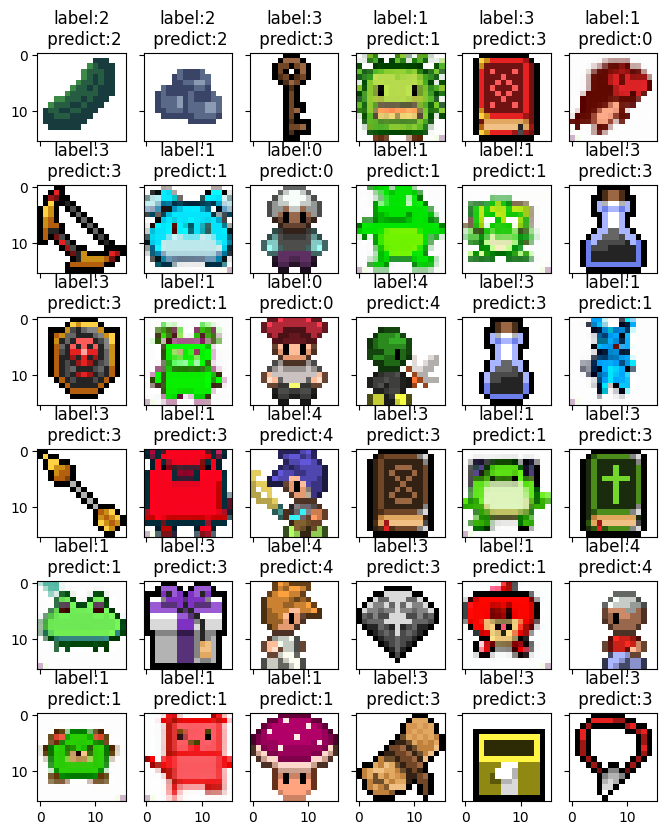

In [47]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=6, ncols=6,figsize=(8, 10), \
                        sharey=True, sharex=True)
random_pic = np.random.choice(range(0, len(val_dataset)), 36, replace=False)


for i, fig_x in zip(random_pic, ax.flatten()):
    im_val, label = val_dataset[i]
    predict = predict_one_sample(pretrained_model, im_val.unsqueeze(0))
    im_val = (im_val + 1) / 2
    fig_x.imshow(np.transpose(im_val, (1, 2, 0)))
    fig_x.set_title("label:" + str(int(label)) + "\n predict:" + str(int(predict[0])))
    fig_x.grid(False)


In [22]:
torch.save(pretrained_model.state_dict(), "discriminator.pt")